# **Построение социального графа**

В данной работе мы построим социальный граф для пользователей одного узла в платформе Mastodon. Cтоит отметить, что граф будет строиться только для пользователей зарегистрированных в главном узле, остальные пользователи не будут добавляться в граф. Ниже мы устанавливаем библиотеку **Mastodon.py** которая поможет удобно получить данные о пользователях. 

In [ ]:
!pip install Mastodon.py

Чтобы пользоваться данным API нужно будет зарегистрироваться на выбранном сервере и также после этого создать приложение использовав код ниже (приложение нужно создавать один раз для сервера). Также важно сохранить файл который указан в переменной to_file так как в нем будет храниться специальный ключ. 

In [ ]:
from mastodon import Mastodon

app_name = 'social_graph'

'''
Mastodon.create_app(
    app_name,
    api_base_url = 'https://horrorhub.club/',
    to_file = 'token1.txt'
)
'''


Далее запускаем функцию login и первым аргументом передаем путь к выше созданному файлу (содержащему токен), а вторым аргументом дополнительный файл который содержит личные данные (первая строчка почта, вторая пароль, третья файл в который сохранится дополнительная необходимая информация). 

In [ ]:
def login(client_id_path, personal_data_path):
  mastodon = Mastodon(client_id=client_id_path, )

  f = open(personal_data_path, "r")
  mail = f.readline()
  mail = mail.replace('\n', '')

  password = f.readline()
  password = password.replace('\n', '')

  to_file = f.readline()
  to_file = to_file.replace('\n', '')
  f.close()

  mastodon.log_in(
      mail,
      password,
      to_file=to_file
  )

  return mastodon

mastodon = login('tokens.txt', 'psd.txt')



Теперь прописываем функции get_followers и get_following, которые возвращают списки никнеймов подписчиков и подписок для указанного пользователя. Данные списки могут содержать людей из других серверов, узнать их можно по псевдониму так как они содержат в имени название своего сервера. Поэтому добавляем дополнительную функцию find_main_domains, которая оставляет никнеймы людей с главного сервера и возвращает новый список. 

In [ ]:
def get_followers(self, acct):
    user_id = Mastodon.account_lookup(self=self, acct=acct)['id']
    followers = Mastodon.account_followers(self=mastodon, id=user_id)
    names = []

    for follower in followers:
        names.append(follower['acct'])

    return names


def get_following(self, acct):
    user_id = Mastodon.account_lookup(self=self, acct=acct)['id']
    followers = Mastodon.account_following(self=mastodon, id=user_id)
    names = []

    for follower in followers:
        names.append(follower['acct'])

    return names


def find_main_domains(followers):
    new_list = []
    for follower in followers:
        if not ('@' in follower):
            new_list.append(follower)

    return new_list

Далее используя алгоритма обхода графа (Depth-First Search), мы пишем функцию get_graphs которая заполняет два словаря. Первый followers_graph, где ключ имя, а значение список подписчиков. Второй словарь following_graph вместо списка подписчиков, содержит список подписок. 

In [ ]:
followers_graph = {}
following_graph = {}

def get_graphs(user_name):
    if user_name in followers_graph.keys() and user_name in following_graph.keys():
        return

    # followers
    user_followers = get_followers(self=mastodon, acct=user_name)
    user_followers = find_main_domains(user_followers)
    followers_graph[user_name] = user_followers

    # following
    user_following = get_following(self=mastodon, acct=user_name)
    user_following = find_main_domains(user_following)
    following_graph[user_name] = user_following

    for follower in user_followers:
      if follower in followers_graph.keys():
        continue

      get_graphs(follower)

    for following in user_following:
      if following in following_graph.keys():
        continue

      get_graphs(following)


get_graphs('zif')
print(followers_graph)

{'zif': ['periplum', 'owl'], 'periplum': ['set', 'altimon', 'zif', 'sdatsenko', 'Bambi', 'sia', 'owl'], 'set': ['zavolodko', 'Alla', 'VBurlikov', 'olenakra', 'serhiikykot'], 'zavolodko': ['Chorna_Olena', 'set'], 'Chorna_Olena': ['Alla', 'VBurlikov', 'set'], 'Alla': ['Chorna_Olena', 'VBurlikov', 'set'], 'VBurlikov': ['Chorna_Olena', 'Alla', 'set'], 'serhiikykot': ['Alla', 'inessashel', 'VBurlikov', 'olenakra', 'set'], 'inessashel': ['set', 'olenakra'], 'olenakra': ['Alla', 'inessashel', 'VBurlikov', 'set', 'serhiikykot'], 'altimon': ['periplum'], 'Lesya': ['altimon', 'sdatsenko', 'owl', 'periplum'], 'sdatsenko': ['periplum', 'Bambi'], 'Bambi': ['sdatsenko', 'owl', 'periplum'], 'owl': ['altimon', 'OlegNitz', 'zif', 'sdatsenko', 'Bambi', 'Lesya', 'sia', 'periplum'], 'OlegNitz': [], 'sia': ['sdatsenko', 'owl', 'periplum'], 'zhenyalin': ['Lesya', 'altimon', 'periplum', 'owl'], 'nsemergey': ['owl', 'periplum'], 'lyolik': ['sdatsenko', 'periplum', 'owl']}


Теперь мы заполняем матрицу, которая является первой репрезентацией нашего графа. 

In [ ]:
import numpy as np

all_users = list(followers_graph.keys())
N = len(all_users)

arr = np.zeros((N,N))

for i in range(N):
  user1 = all_users[i]
  for j in range(N):
    user2 = all_users[j]
    user2_subs = followers_graph[user2]

    # if user1 subscribes to user2
    if user1 in user2_subs:
      arr[i][j] += 1


for i in range(N):
  user1 = all_users[i]
  for j in range(N):
    user2 = all_users[j]
    user2_subs = following_graph[user2]

    # if user1 subscribes to user2
    if user1 in user2_subs:
      arr[i][j] += 1


Чтобы наглядно показать ее используем модуль pyplot. (Черный цвет на пересечении означает, что никто не подписан, зеленый, что кто-то один подписан и желтый означает взаимную подписку. 

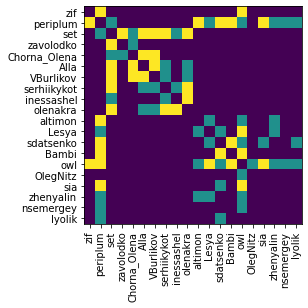

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(arr)
plt.yticks(range(N), all_users)
plt.xticks(range(N), all_users, rotation=90)
plt.show()

Для того чтобы построить обычный вид графа, нужно использовать дополнительные библиотеки. Однако для удобства сначала мы соберем данные в таблицу pandas. Также люди со взаимной подпиской (weight=2) буду иметь красный цвет связи, а односторонней подпиской (weight=1) синий цвет.

> Блок с отступами



In [ ]:
import pandas as pd


dict = {'Source': ['test'],
                   'Target': ['test'],
                   'weight': [0],
        'color': ['red']}
df = pd.DataFrame(dict)

some_set = []
for i in range(N):
  user1 = all_users[i]
  some_set.append(user1)

  for j in range(N):
    user2 = all_users[j]

    if user2 in some_set:
      continue

    weight = arr[i][j]
    color = None
    if weight == 2:
      color = 'red'
    else:
      color = 'blue'

    if weight > 0:
      df.loc[len(df.index)] = [user1, user2, weight, color]

df = df.drop(0)
df

,Source,Target,weight,color
1,zif,periplum,2.0,red
2,zif,owl,2.0,red
3,periplum,set,1.0,blue
4,periplum,altimon,2.0,red
5,periplum,Lesya,1.0,blue
6,periplum,sdatsenko,2.0,red
7,periplum,Bambi,2.0,red
8,periplum,owl,1.0,blue
9,periplum,sia,2.0,red
10,periplum,zhenyalin,1.0,blue


Теперь с помощью networkx строим простой граф

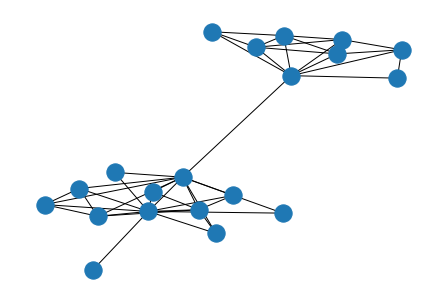

In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr=['weight', 'color'])
nx.draw(G)

Однако чтобы построить более детальный и даже анимированный граф, устанавливаем библиотеку pyvis.


In [ ]:
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.9/748.9 KB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.8 MB/s eta 0:00:00
  Created wheel for pyvis: filename=pyvis-0.3.1-py3-none-any.whl size=755850 sha256=cff4fbb7fc4f6d9fc5faf204f5aa081a590a00bb8fb721e4a6847f300e819883
  Stored in directory: /root/.cache/pip/wheels/a4/0c/61/8469ca276f96ab772c3acc7f47d71e9737cbdf6f446f017f48
Successfully built pyvis


После выполнения кода ниже, скачивается html файл. Открываем его и смотрим на результат. 

In [ ]:
from pyvis.network import Network

net = Network(notebook=True)

net.from_nx(G)
net.show('graph1.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
